In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  6 22:09:50 2020

@author: ivan
"""

#import json
#data=json.loads("Thermal_crop/.exports/coco-1602040595.8348284.json")
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import json
import csv
import argparse
import os
import sys
import time
import numpy as np
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)
#COCO_MODEL_PATH ="/content/drive/My Drive/Mask_RCNN-master/samples/test/logs/coco20201029T2311/mask_rcnn_coco_0025.h5"#8
MODEL_DST_PATH=os.path.join(ROOT_DIR,"samples","test1", "Trained_Model_2")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR,"samples","test1","logs_2")
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import model as modellib, utils
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"
    
    STEPS_PER_EPOCH = 100
    
    VALIDATION_STEPS = 30
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES =4  # COCO has 80 classes
    DETECTION_MAX_INSTANCES=100
    #IMAGE_RESIZE_MODE = "none"
    #IMAGE_MAX_DIM = 1920

class CocoDataset(utils.Dataset):
    def load_coco(self, dataset_dir,subset,porcentaje, class_ids=None,
                  class_map=None, return_coco=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """

        coco = COCO(dataset_dir)
        #print (coco)
        image_dir = subset

        # Load all classes or a subset?
        #if not class_ids:
            # All classes
        class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])
               # Add images
        cantidadImagenes=int(len(coco.getImgIds())*porcentaje)
        print("Los datos utilizarán:"+str(cantidadImagenes)+" de:"+str(len(coco.getImgIds()))+"imagenes")
        count=0
        print('usando: '+str(class_ids[1])+" que pertenece a: "+ coco.loadCats(class_ids[1])[0]["name"])
        for i in image_ids:
       
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
                
              
            count+=1
            if count ==cantidadImagenes:
                break
        #print("Prueba Linea 101"+str(len(self.image_ids())))
        if return_coco:
            return coco
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)        
    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

############################################################
#  COCO Evaluation
############################################################

def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results
def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)
    


C:\Users\ivanc\Desktop\UNIVERSIDADDEIBAGUE\Investigacion\Instance_Segmentation\Mask-RCNN-TF2-master


Using TensorFlow backend.


In [4]:
# asd=CocoDataset()
# asd.load_coco("/Thermal_crop","")


# Configurations
config = CocoConfig()
# Create model COCO_MODEL_PATH
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DST_PATH)

model.set_log_dir(DEFAULT_LOGS_DIR)#.replace("//","/"))
model_path = os.path.join(MODEL_DST_PATH,"coco20230607T1317","mask_rcnn_coco_0018.h5")
print("Loading weights ", model_path)
model.load_weights(model_path, by_name=True)


# Train or evaluate
# Training dataset. Use the training set and 35K from the
# validation set, as as in the Mask RCNN paper.
dataset_train = CocoDataset()
dataset_train.load_coco(r'C:/Users/ivanc/Desktop/UNIVERSIDADDEIBAGUE/Investigacion/Instance_Segmentation/Mask-RCNN-TF2-master/samples/test1/macetas_db/.exports/coco-1686156855.7441359.json','macetas_db/',porcentaje=1)
dataset_train.prepare()

#     # Validation dataset
dataset_val = CocoDataset()
#     val_type = "val" if args.year in '2017' else "minival"
dataset_val.load_coco(r'C:/Users/ivanc/Desktop/UNIVERSIDADDEIBAGUE/Investigacion/Instance_Segmentation/Mask-RCNN-TF2-master/samples/test1/macetas_db/.exports/coco-1686156855.7441359.json','macetas_db/',porcentaje=1)
dataset_val.prepare()
     # Image Augmentation
#     # Right/Left flip 50% of the time
augmentation = imgaug.augmenters.Fliplr(0.5)

#     # *** This training schedule is an example. Update to your needs ***

     # Training - Stage 1
#augmentation = imgaug.augmenters.geometric.Affine(scale=(0.4,1.5))

Loading weights  C:\Users\ivanc\Desktop\UNIVERSIDADDEIBAGUE\Investigacion\Instance_Segmentation\Mask-RCNN-TF2-master\samples\test1\Trained_Model_2\coco20230607T1317\mask_rcnn_coco_0018.h5
Re-starting from epoch 18
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Los datos utilizarán:3 de:3imagenes
usando: 11 que pertenece a: maleza
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Los datos utilizarán:3 de:3imagenes
usando: 11 que pertenece a: maleza


In [ ]:

print("Training network")
model.train(dataset_train, dataset_val,learning_rate=0.001,epochs=20,layers='all',augmentation=augmentation)
#model.train(dataset_val, dataset_val,learning_rate=0.0003,epochs=62,layers='all')

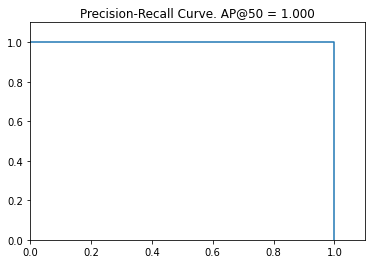

In [13]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [5]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import os
import sys
ROOT_DIR = os.path.abspath("../../")
MODEL_DST_PATH=os.path.join(ROOT_DIR,"samples","test1", "Trained_Model_2")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR,"samples","test1","logs_2")
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"
    
    STEPS_PER_EPOCH = 100
    
    VALIDATION_STEPS = 30
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES =4  # COCO has 80 classes
    DETECTION_MAX_INSTANCES=100
    #IMAGE_RESIZE_MODE = "none"
    #IMAGE_MAX_DIM = 1920
    
config = CocoConfig()

config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"samples","test1", "Trained_Model", "mask_rcnn_coco_0004.h5")
#config = CocoConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DST_PATH, config=config)
model_path = os.path.join(MODEL_DST_PATH,"coco20230607T1317","mask_rcnn_coco_0018.h5")
print("Loading weights ", model_path)
model.load_weights(model_path, by_name=True)

dataset_val = CocoDataset()
dataset_val.load_coco(r'C:/Users/ivanc/Desktop/UNIVERSIDADDEIBAGUE/Investigacion/Instance_Segmentation/Mask-RCNN-TF2-master/samples/test1/macetas_db/.exports/coco-1686156855.7441359.json','macetas_db/',porcentaje=1)
dataset_val.prepare()
#for image_id in dataset_val.image_ids:
    #image=dataset_val.load_image(image_id)
    #image= cv2.resize(image,(1024,1024), interpolation=cv2.INTER_CUBIC)


Loading weights  C:\Users\ivanc\Desktop\UNIVERSIDADDEIBAGUE\Investigacion\Instance_Segmentation\Mask-RCNN-TF2-master\samples\test1\Trained_Model_2\coco20230607T1317\mask_rcnn_coco_0018.h5
Re-starting from epoch 18
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Los datos utilizarán:3 de:3imagenes
usando: 11 que pertenece a: maleza


image ID: coco.7 (2) http://cocodataset.org/#explore?id=7
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


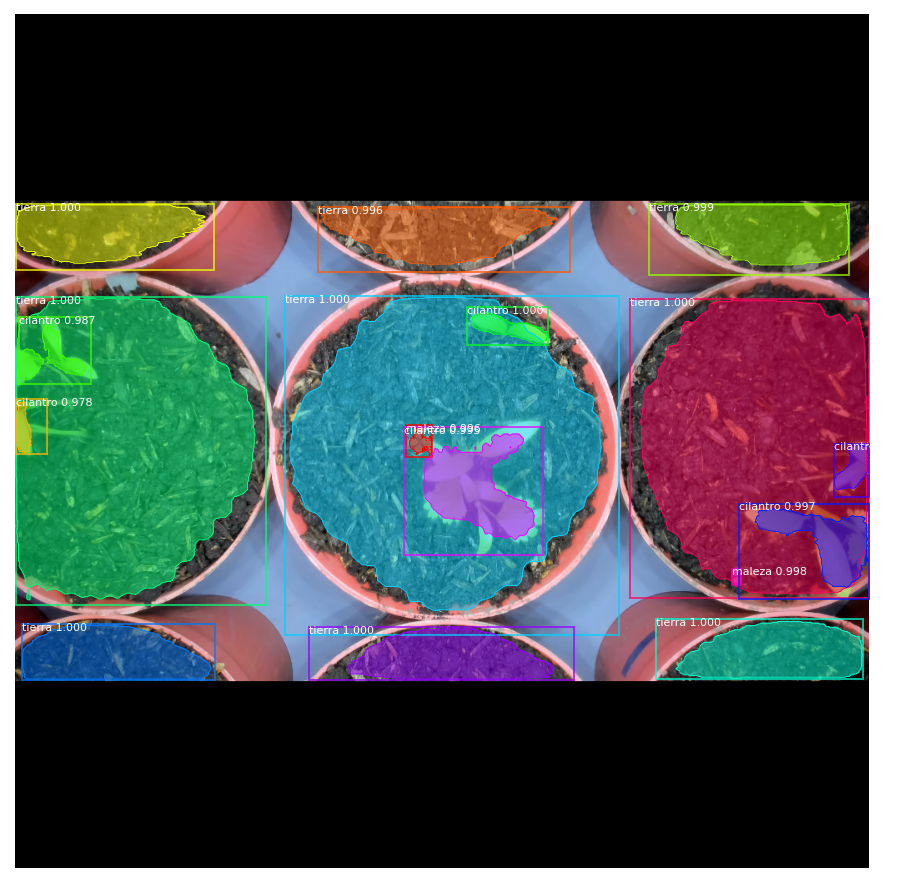

In [26]:
from mrcnn import visualize

image_id = 2#random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                      dataset_val.image_reference(image_id)))    
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   30.10867  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -14.15141  max:   15.18366  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


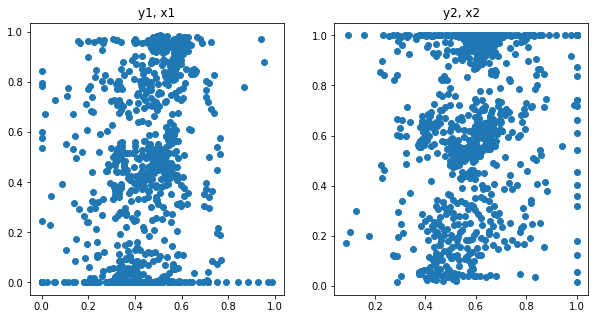

In [22]:
 # Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()

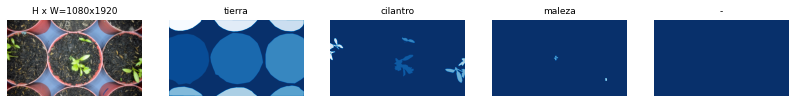

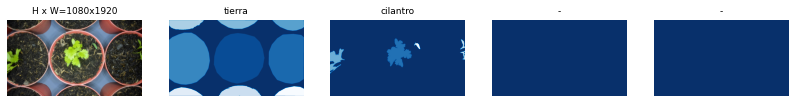

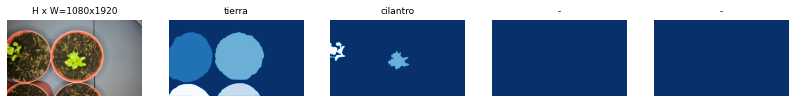

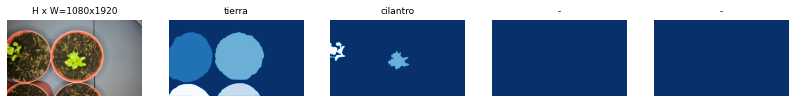

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [24]:
 r['class_ids']

array([3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 1, 3, 2, 1, 1, 1, 1])